In [1]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def load_df(path, encoding="utf-8"):
    loaded_pd = pd.read_csv(path, sep="\t", encoding=encoding)
    pd_name = path.split("/")[-1].split(".")[0]
    return pd_name, loaded_pd

In [3]:
paths_expression = glob.glob("data/expression data/*.txt")

In [4]:
expression_data = []
for path in paths_expression:
    expression_data.append(load_df(path))

In [5]:
paths_other = glob.glob("data/*.txt")
aligner_path = "data/phenotypes_id_aligner.txt"
other_data = []
for path in paths_other:
    if path == aligner_path:
        other_data.append(load_df(path, encoding="latin"))
    else:
        other_data.append(load_df(path))

## We have loaded the dataframes to lists

Each list contains tuples (name, dataframe)
- expression_data: tables with gene expressions
- other_data: all the remaining tables

In [6]:
# Compute the total set of mice strains present in the expressions dataframes
mice_set = set()

for i in range(len(expression_data)):
    df = expression_data[i][1].set_index('gene')
    mice_set.update(list(df.columns))

# Compute the total list of mice strains sorted alphabetically
mice_list = sorted(list(mice_set))
print(len(mice_list))

97


In [7]:
# Create a list of dataframes that always contain all mice (with NaN values if the mice are not originally present)
df_list = []

for i in range(len(expression_data)):
    df = expression_data[i][1].set_index('gene')
    # standardize to fight the issue of different means and deviations - to make all of the values comparable
    df = df.sub(df.mean(1), axis=0).div(df.std(1), axis=0)
    missing_mice = mice_set - set(df.columns)
    for mouse in missing_mice:
        df[mouse] = np.NaN
        
    # Order the columns alphabetically
    df = df[mice_list]
    df.reset_index(inplace=True)
    df["gene"] = df["gene"].apply(lambda name: name + "_" + expression_data[i][0])
    df.rename(columns={"gene": "strain"}, inplace=True)
    df.set_index("strain", inplace=True)
    df_list.append(df.transpose())

In [8]:
base_df = df_list[0]
for other_df in df_list[1:]:
    base_df = base_df.join(other_df)

We note that all in all the tissues apart from [9, 14, 16, 17, 22, 26, 27, 30, 31, 32, 34, 35, 37, 38, 39] the values follow normal distribution. To make all of them comparable we standardize them by (SNP, tissue)

In [10]:
gene_tissue_num = len(base_df.columns)

In [11]:
# we remove the mice for which we have no expression data whatsoever
base_df.drop(base_df[base_df.isnull().sum(axis=1) == gene_tissue_num].index, inplace=True)

We remove the (SNP, tissue) for which we do not have data for at least 4 mice

In [12]:
strains_num = len(base_df)

In [13]:
columns_to_drop = base_df.columns[base_df.isnull().sum(axis=0) > strains_num - 4]

In [14]:
base_df.drop(columns_to_drop, axis=1, inplace=True)

In [16]:
base_df.to_pickle("processed_data/expression_standardized_cleaned.pkl")

In [17]:
phenotype_present = pd.read_pickle("processed_data/pheno_joined_present.pkl")

In [25]:
strains_with_pheno = phenotype_present.columns[:-2]

In [32]:
base_df = base_df.transpose()
base_df.rename(columns={"strain": "SNP"})

strain,Nmt1_10338077_Muscle_CD,Psmb5_10338095_Muscle_CD,Hdac5_10338098_Muscle_CD,Dlg1_10338109_Muscle_CD,Wars_10338116_Muscle_CD,Psph_10338122_Muscle_CD,Copa_10338123_Muscle_CD,Tbl3_10338144_Muscle_CD,Hb1bp3_10338180_Muscle_CD,Aup1_10338221_Muscle_CD,...,AFFX-r2-P1-cre-3_AFFX-r2-P1-cre-5_at_Eye,AFFX-ThrX-3_AFFX-ThrX-3_at_Eye,AFFX-ThrX-5_AFFX-ThrX-5_at_Eye,AFFX-ThrX-M_AFFX-ThrX-M_at_Eye,Tfrc_AFFX-TransRecMur-X57349_3_at_Eye,Tfrc_AFFX-TransRecMur-X57349_5_at_Eye,Tfrc_AFFX-TransRecMur-X57349_M_at_Eye,AFFX-TrpnX-3_AFFX-TrpnX-3_at_Eye,AFFX-TrpnX-5_AFFX-TrpnX-5_at_Eye,AFFX-TrpnX-M_AFFX-TrpnX-M_at_Eye
B6D2F1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.945871,-0.383660,-1.764515,-1.513057,0.618771,1.036264,1.008312,-0.810138,-0.336536,-0.813993
BXD1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.414755,0.599324,0.185117,1.277075,-0.501507,-0.566462,-0.427261,-0.273595,-2.101328,1.004035
BXD100,-0.725161,0.007720,0.376058,0.545516,-1.104466,-0.273818,-0.901318,-0.509151,-0.924874,0.986363,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BXD101,-1.317918,1.462562,0.845329,0.515211,-1.058281,-0.056781,-0.942842,-0.953912,0.496976,0.299762,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BXD102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BXD98,2.220295,-1.073020,0.193564,0.252363,1.052343,-1.433933,-0.207268,1.668022,0.450924,-0.547979,...,-0.644823,-0.666892,0.167393,-0.138813,-0.566410,-0.740733,-0.645876,-0.672170,-1.854257,0.509659
BXD99,-1.305697,0.207241,1.453644,0.255455,-0.748846,0.607248,-0.625478,1.101311,-1.224210,-0.611035,...,-0.056785,0.899217,-0.612460,-0.721825,-0.826021,-0.757874,0.082841,-0.610851,1.463552,1.673835
C57BL.6J,-1.929009,-0.557591,-0.353919,-0.014195,0.050143,-1.273739,-0.064899,-0.132540,-0.677345,2.506693,...,1.535355,-0.017124,-1.285969,-2.491685,0.734467,0.979126,0.822489,-1.086075,-0.830678,-0.112298
D2B6F1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.563092,2.631934,0.185117,-2.366754,0.130589,0.744860,0.724112,-0.518872,0.192902,-1.196735


In [104]:
strain_with_pheno = []
for index, row in phenotype_present.iterrows():
    strain_with_pheno.append(row[~row.isnull()].index.tolist()[:-2])

B6D2F1                                                         0
D2B6F1                                                       NaN
C57BL.6J                                                       0
DBA.2J                                                       100
BXD1                                                        66.7
                                     ...                        
BXD100                                                      11.1
BXD101                                                       NaN
BXD102                                                       NaN
Shown_pheno    H5N1 influenza A virus mortality rate 30 days ...
Disease                                                Influenza
Name: X657, Length: 99, dtype: object


In [95]:
# 1. select strain with largest number of SNPs

# 2. as testing for all 2^86 subsets of strains that might have common expressions present is computationally infeasible, we employ a simple strategy:
# greedily add strains that reduce the number of common SNPs the least

# for now, to simplify even more, we just replace the missing values with mean

In [135]:
df_pheno = []
for index, row in phenotype_present.iterrows():
    row = row[~row.isna()]
    row_df = pd.DataFrame(row)
    column_name = row_df.columns[0]
    row_df.rename(columns={column_name: row["Shown_pheno"]}, inplace=True)
    df_pheno.append(base_df.join(row_df, how="inner"))

In [4]:
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split

In [253]:
pheno_idx_of_interest = [0, 1, 2, 3, -1, -2]
malaria_susceptibility_idx = [-1]

In [264]:
import random
positive_test_score = 0
num_tests = 20
for random_state in range(num_tests):
    for pheno_idx in malaria_susceptibility_idx:    
        X_train, X_test, y_train, y_test = train_test_split(
            df_pheno[pheno_idx].iloc[:, :-1].fillna(0), df_pheno[pheno_idx].iloc[:, -1].fillna(0), test_size=0.3, random_state=random_state)

        clf = RidgeCV(alphas=[1e-99, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9, 1e10, 1e11, 1e12]).fit(X_train, y_train)
        if (clf.alpha_ == 1e12 or clf.alpha_ == 1e-5):
            print(clf.alpha_)
            print("Might need to update alpha")
        test_score = clf.score(X_test, y_test)
        if test_score > 0:
            positive_test_score += 1
        print(f"{df_pheno[pheno_idx].columns[-1]}, test+score: {test_score}, number_of_samples: {len(df_pheno[pheno_idx])}")
print(f"percentage of positive R^2 scores: {float(positive_test_score) / num_tests * 100}")

Malaria susceptibility, murine Plasmodium yoelli 17X-lethal (PY17X-L) [0=100% resistant, 1= 100% susceptible], test+score: 0.10180054576042086, number_of_samples: 57
Malaria susceptibility, murine Plasmodium yoelli 17X-lethal (PY17X-L) [0=100% resistant, 1= 100% susceptible], test+score: 0.1396917513959589, number_of_samples: 57
Malaria susceptibility, murine Plasmodium yoelli 17X-lethal (PY17X-L) [0=100% resistant, 1= 100% susceptible], test+score: 0.12795961323819005, number_of_samples: 57
Malaria susceptibility, murine Plasmodium yoelli 17X-lethal (PY17X-L) [0=100% resistant, 1= 100% susceptible], test+score: 0.16958417245691862, number_of_samples: 57
Malaria susceptibility, murine Plasmodium yoelli 17X-lethal (PY17X-L) [0=100% resistant, 1= 100% susceptible], test+score: 0.2751187703390874, number_of_samples: 57
Malaria susceptibility, murine Plasmodium yoelli 17X-lethal (PY17X-L) [0=100% resistant, 1= 100% susceptible], test+score: -0.07999826243561481, number_of_samples: 57
Malar

We conclude that The ridge regression classifier does better than it would by always guessing the expected value, so it is a good baseline and the phenotype appears to be somewhat predictible give the gene expression data.

In [308]:
# we compare ridge regression with expected value error
df_malaria = df_pheno[-1]

In [317]:
df_malaria.to_pickle("processed_data/malaria_susceptibility.pkl")

In [6]:
X_train, y_train = df_malaria.iloc[:, :-1].fillna(0), df_malaria.iloc[:, -1].fillna(0)
clf_alpha = RidgeCV(alphas=np.linspace(7000, 7049, 1000), store_cv_values=True).fit(X_train, y_train)
print(f"best alpha: {clf_alpha.alpha_}")

best alpha: 7033.794794794795


In [5]:
clf = RidgeCV(alphas=[clf_alpha.alpha_], store_cv_values=True).fit(X_train, y_train)

print(f"{df_malaria.columns[-1]}, number_of_samples: {len(df_malaria)}")
print(f"mean error: {clf.cv_values_.mean()}")
print(f"mean error for completely susceptible mice: {clf.cv_values_[np.where(y_train == 1.0)[0]].mean()}")
print(f"mean error for somewhat resistant mice: {clf.cv_values_[np.where(y_train != 1.0)[0]].mean()}")

NameError: name 'clf_alpha' is not defined

Text(0.5, 0, 'malaria susceptibility %')

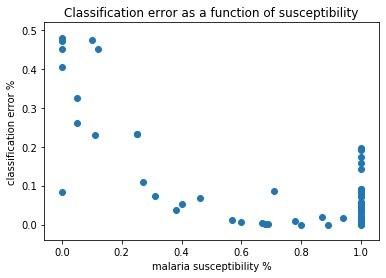

In [315]:
# error distribution by mice susceptibility
plt.scatter(x=y_train, y=clf.cv_values_)
plt.title("Classification error as a function of susceptibility")
plt.ylabel("classification error %")
plt.xlabel("malaria susceptibility %")

We note that the classifier makes the worst mistakes when predicting susceptibility of the most resistant mice.

(array([9.00000e+00, 2.02000e+02, 4.57100e+03, 8.31610e+04, 5.60186e+05,
        4.96384e+05, 5.36320e+04, 2.80700e+03, 2.57000e+02, 2.20000e+01]),
 array([-2.55293652e-05, -2.03659262e-05, -1.52024872e-05, -1.00390482e-05,
        -4.87560913e-06,  2.87829891e-07,  5.45126891e-06,  1.06147079e-05,
         1.57781470e-05,  2.09415860e-05,  2.61050250e-05]),
 <a list of 10 Patch objects>)

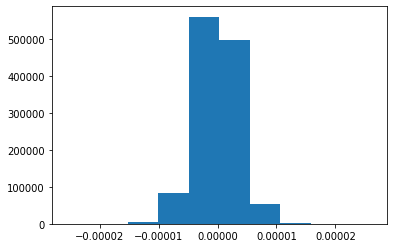

In [322]:
plt.hist(clf.coef_)

Most of the weights are very small, meaning most of the expression data is not used. It appears that there are both gene expressions that correlate with susceptibility as those related to resistance: the histogram has negative and positive entries.

SNPs used by classifier to predict susceptibility:

In [338]:
X_train.columns[np.where(clf.coef_ > 0.000023)[0]]

Index(['scl00280487.1_157-S_ILM5910112_Bone_Femur',
       '1700072I22Rik_ILM100380731_Bone_Femur', 'Cpn1_ILM1940114_Bone_Femur',
       'Lonp2_ILM5290687_Bone_Femur', 'Serpina1-rat_ILM106590035_Bone_Femur'],
      dtype='object')

SNPs used by classifier to predict resistance:

In [339]:
X_train.columns[np.where(clf.coef_ < -0.0000215)[0]]

Index(['Gpr83_ILM102940402_Bone_Femur', 'Cntnap2_ILM100380601_Bone_Femur',
       'Car10_ILM3130463_Bone_Femur', 'Nppc_ILM2320647_Bone_Femur',
       '4930571N24Rik_ILM101230041_Bone_Femur'],
      dtype='object')

It seems that gene expression in bone femur is the strongest indicator

In [ ]:
from scipy.stats import spearmanr
spearman_correlation = spearmanr(X_train, y_train)